# Implementation of paper **"A Hybrid Deep Feature Selection Framework for Emotion Recognition from Human Speeches"**
[Paper](https://link.springer.com/article/10.1007/s11042-022-14052-y) | [Code Repostiry](https://github.com/soumitri2001/Wrapper-Filter-Speech-Emotion-Recognition)


### Preprerd by:
- Sarah Khalid Alaradi | 440023365 | skmaloridi@sm.imamu.edu.sa 
- Shoug Ali Alsuhaibani | 440022732 | ssuhaibani@sm.imamu.edu.sa 
- Reem Abdulmohsen Alqahtani | 440019278 | rasalkahtani@sm.imamu.edu.sa 
- Reema Mohammed Aloqayli | 440025060 | rmnaloqayli@sm.imamu.edu.sa 
- Norah Ahmed Alsharhan | 440022381 | nalsharhan@sm.imamu.edu.sa 


#### Supervisor: Dr. Wojdan BinSaeedan 

# Overall Workflow
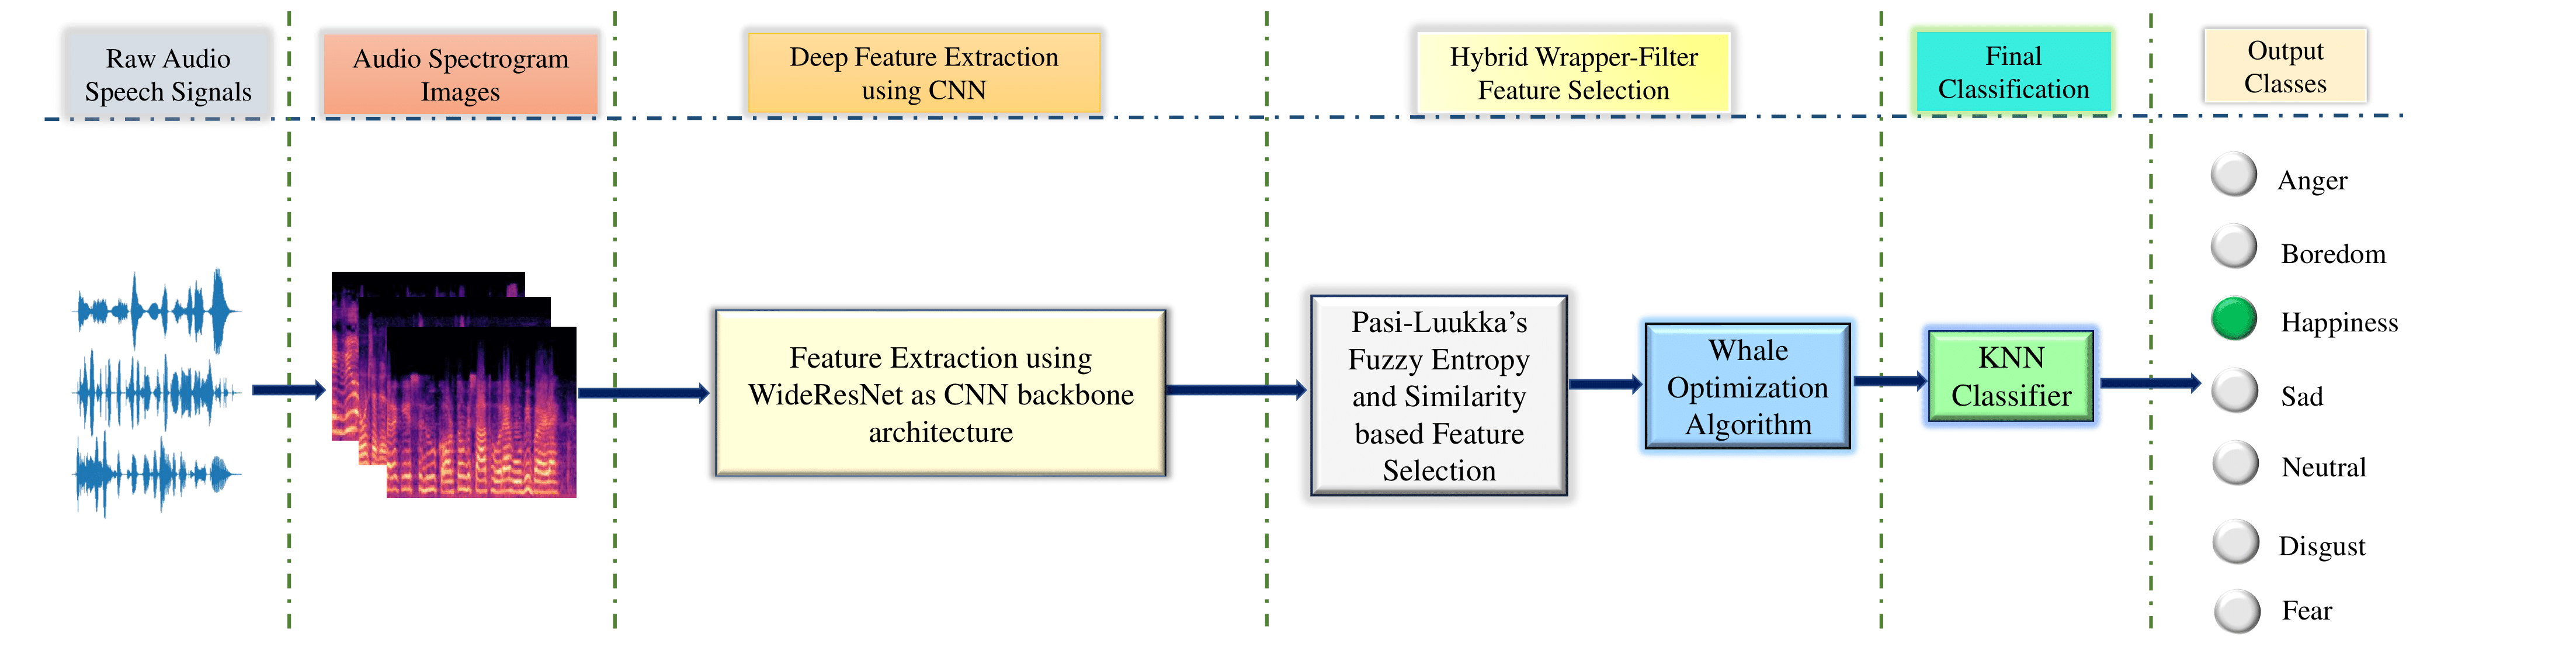

# Importing Libraries
Imports all necessary libraries.

In [6]:
import os
import copy
import time
import argparse
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torch.nn as nn
import torchvision
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import auc, precision_score, classification_report, ConfusionMatrixDisplay, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as KNN
import warnings
warnings.filterwarnings('ignore')

Importing the six custom libraries:
- `dataset` : return a dictionary of training and validation dataloaders.
- `visualize` : return a plots to the hisoty and confusion matrix.
- `model` : to get and extact the feature and train the model.
- `feature_selection` : filter based feature selection with utility functions.
- `PasiLuukka` : Feature selection filter based using fuzzy entropy and similarity.
- `WOA_FS` : whale optimization algoritm to select features.





  

In [35]:
# custom libraries 
from utils.dataset import get_dataloader
from utils.visualize import plot_TL_history, plot_ConfMatrix
from model import SER_Network, train_model, extract_features, get_features
from utils.feature_selection import *
from PasiLuukka import pasi_luukka
from WOA_FS import whale_optim_algo

# Convert Audio to image
The first step in this project wil start by converting all audio to image to use it as input to the model.


In [23]:
# for each class  "Boredom", "Fear","Disgust","Happiness", "Sadness","Anger","Neutral" run this command

#!python audio2spectrogram.py --audio_dir "./data_audio/val/Neutral" --data_dir "./data_image/val/Neutral"

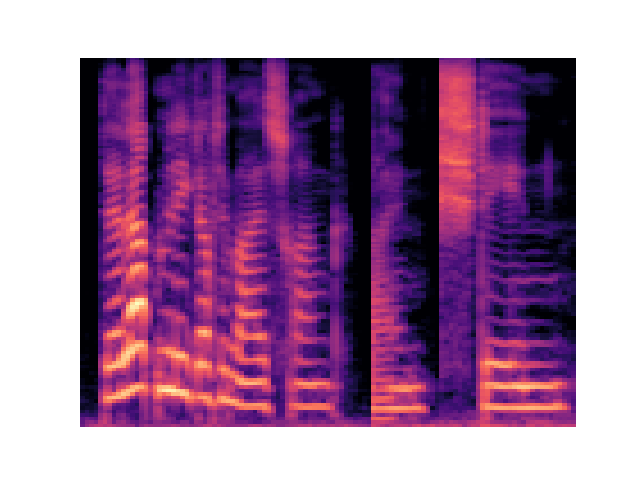

In [24]:
# This image shows the anger audio spectrogram image
image = Image.open('./data_image/train/Boredom/08a01Lc.wav.png')
image.show()


# Assign values to the required variables 
Define variables with defalut values. 

In [25]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# data_dir = "./data_image" 
# num_epochs =  100 #defalut value
# batch_size =  4   #defalut value
# learning_rate = 0.0005 #defalut value
# optimizer = "SGD"
# saved_models = os.getcwd()+"/saved_models/"
# saved_figures = os.getcwd()+"/figures/"
# saved_features = os.getcwd()+"/saved_features/"

args = {
    'data_dir': "./data_image",
    'num_epochs': 100,
    'batch_size': 4,
    'learning_rate': 0.005,
    'optimizer': "SGD",
    'saved_models': os.getcwd() + "/saved_models/",
    'saved_figures': os.getcwd() + "/figures/",
    'saved_features': os.getcwd() + "/saved_features/"
}

# CLI arguments
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument('--data_dir', type=str, default="./data_image", help='path to directory where image data is stored')
parser.add_argument('--num_epochs', type=int, default=100, help='number of training epochs')
parser.add_argument('--batch_size', type=int, default=4, help='batch size for training')
parser.add_argument('--learning_rate', type=float, default=0.0005, help='learning rate for training')
parser.add_argument('--optimizer', type=str, default="SGD", help='optimizer for training: SGD / Adam')
parser.add_argument('--saved_models', type=str, default=os.getcwd() + "/saved_models/", help='path to directory to saved models')
parser.add_argument('--saved_figures', type=str, default=os.getcwd() + "/figures/", help='path to directory to save figures')
parser.add_argument('--saved_features', type=str, default=os.getcwd() + "/saved_features/", help='path to directory to save features')

# Parse the arguments
args = parser.parse_args(args=[])


# Create Storage Directories
Checks if the storage directories for saved models, figures, and features exist. If not, creates the directories.

In [26]:
if not os.path.isdir(args.saved_models):
        os.mkdir(args.saved_models)
if not os.path.isdir(args.saved_figures):
        os.mkdir(args.saved_figures)
if not os.path.isdir(args.saved_features):
        os.mkdir(args.saved_features)

# Getting Dataloaders
The data loads using pytorch then make a transformations to all image. 
transformations list: 
- resize by 224x224
- convert to tensor 
- normlize the tensor.

This function return a 2 dictionaries one for the data loaders and the other to classes-to-index.

In [27]:
classes_to_idx, data_loader = get_dataloader(args)
print('-------------------------------------------------------------------------')

NUM_CLASSES = len(classes_to_idx)
PHASES = data_loader.keys()
for phase in PHASES:
    print(f'Length of {phase} loader = {len(data_loader[phase])}')
print('-------------------------------------------------------------------------')


Length of train dataset: 424 
Length of validation dataset: 104
-------------------------------------------------------------------------
Length of training loader = 106
Length of validation loader = 104
-------------------------------------------------------------------------


 # Initializing Model, Optimizer, Loss Function
 
 1. Creates an instance of the SER_Network model.

 2. Moves the model to the available device (GPU if available, otherwise CPU).

 3. Defines the cross-entropy loss function.

 4. Initializes the optimizer with learning rate that assigned by the arguments.

In [28]:
model = SER_Network(num_classes=NUM_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

if args.optimizer.upper() not in ['SGD', 'ADAM']:
    args.optimizer = 'SGD'

if args.optimizer.upper() == 'ADAM':
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate, momentum=0.9)



# Train and Evaluate CNN Model using 5-fold Cross-Validation

1. Performs 5-fold cross-validation using StratifiedKFold.
2. Prints the progress and results for each fold.
3. Saves the best model for each fold.
4. Plots the learning curves.


MODEL TRAINING BEGINS: 
-------------------------------------------------------------------------
Epoch: [1/100] | Phase: training | Loss: 1.831085 | Accuracy: 0.250000
Epoch: [1/100] | Phase: validation | Loss: 1.797508 | Accuracy: 0.317308
====> Best accuracy reached so far at Epoch 1 | Accuracy = 0.317308
-------------------------------------------------------------------------
Epoch: [2/100] | Phase: training | Loss: 1.431859 | Accuracy: 0.537736
Epoch: [2/100] | Phase: validation | Loss: 1.545281 | Accuracy: 0.394231
====> Best accuracy reached so far at Epoch 2 | Accuracy = 0.394231
-------------------------------------------------------------------------
Epoch: [3/100] | Phase: training | Loss: 1.046178 | Accuracy: 0.709906
Epoch: [3/100] | Phase: validation | Loss: 1.373259 | Accuracy: 0.480769
====> Best accuracy reached so far at Epoch 3 | Accuracy = 0.480769
-------------------------------------------------------------------------
Epoch: [4/100] | Phase: training | Loss: 0.5

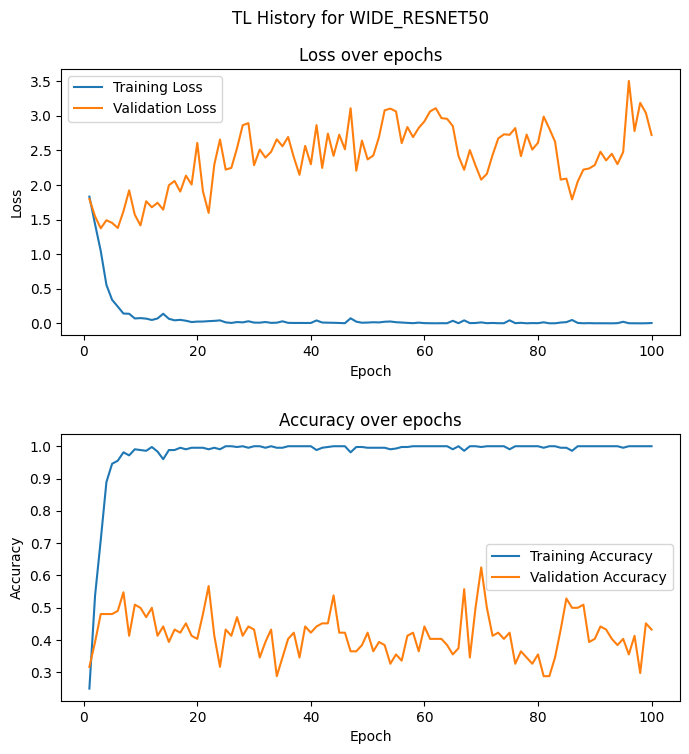

In [29]:
### train CNN model on dataset ###
print("MODEL TRAINING BEGINS: ")
print('-------------------------------------------------------------------------')
model, history = train_model(args, model, criterion, optimizer, data_loader, PHASES) 
print('-------------------------------------------------------------------------')

### saving final model ###
torch.save(model.state_dict(), os.path.join(args.saved_models, f'{model.MODEL_NAME}.pth'))

### get history to CPU from cuda ###
for i in range(args.num_epochs):
    history['train_acc'][i] = history['train_acc'][i].cpu().numpy().item() 
    history['val_acc'][i] = history['val_acc'][i].cpu().numpy().item()

### plot learning curves ###
plot_TL_history(args, history, model.MODEL_NAME)


 # Feature Extraction using the Trained CNN
1. Performs feature extraction using the trained CNN model on the dataset.
2. Prints the total number of features obtained after each phase.

In [30]:
### feature extraction using the trained CNN ###
print("FEATURE EXTRACTION BEGINS: ")
print('-------------------------------------------------------------------------')

args.batch_size = 1 # for feature extraction
_, data_loader = get_dataloader(args)

features, true_labels, paths = [], [], []
for phase in data_loader.keys():
    features, true_labels, paths = extract_features(features, true_labels, paths, model, data_loader[phase], phase)
    print(f'Total feature set after {phase} phase extraction: {len(features)}')
print('-------------------------------------------------------------------------')


FEATURE EXTRACTION BEGINS: 
-------------------------------------------------------------------------
Length of train dataset: 424 
Length of validation dataset: 104
Accuracy of model on training set = 100.0000 %
Total feature set after training phase extraction: 424
Accuracy of model on validation set = 62.5000 %
Total feature set after validation phase extraction: 528
-------------------------------------------------------------------------


# Get Feature Vectors and Save Features to CSV
1. Converts the features, true labels, and paths to numpy arrays.
2. Reshapes the feature vectors and saves them, along with the corresponding labels and file paths, to a CSV file.

In [31]:
# get feature vectors from torch tensors
features, true_labels, paths = get_features(features, true_labels, paths)

# save features to csv file
features_df = pd.DataFrame(features)
features_df['filename'] = paths.copy()
features_df['label'] = true_labels.copy()
features_df.to_csv(os.path.join(args.saved_features, f"{model.MODEL_NAME}_features.csv"),index=False)
print(f'feature set obtained by {model.MODEL_NAME} saved successfully !')
print('-------------------------------------------------------------------------')


feature set obtained by WIDE_RESNET50 saved successfully !
-------------------------------------------------------------------------


#  Feature Selection using Passi-Luukka's Method of Fuzzy Entropy and Similarity Measures
1. Performs feature selection using Passi-Luukka's method on the extracted features.
2. Obtains the selected feature subset.

In [32]:
### Feature selection using Passi-Luukka's method of Fuzzy Entropy and Similarity Measures ###
X = features_df.iloc[:,0:(features_df.shape[1]-2)].copy()
y = features_df['label'].copy()

X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

sol_filter = pasi_luukka(X, y)
X1 = sol_filter.ranked_features[:, 0:256].copy()


(528, 512) (528,)


# Feature Selection using Whale Optimization Algorithm

1. Splits the data into training and validation sets.
2. Performs feature selection using the Whale Optimization Algorithm (WOA) on the selected feature subset.


In [33]:
data = Data()
data.train_X, data.val_X, data.train_Y, data.val_Y = train_test_split(X1, y, test_size=0.2, shuffle=False, random_state=1)

sol_WOA = whale_optim_algo(num_agents=40, max_iter=100, data=data)
print('-------------------------------------------------------------------------')


Streaming output truncated to the last 5000 lines.
Whale 25 - Fitness: 0.5264954304245284,Accuracy: 0.5283018867924528, Number of Features: 167
Whale 26 - Fitness: 0.5252454304245283,Accuracy: 0.5283018867924528, Number of Features: 199
Whale 27 - Fitness: 0.5249719929245283,Accuracy: 0.5283018867924528, Number of Features: 206
Whale 28 - Fitness: 0.5249329304245284,Accuracy: 0.5283018867924528, Number of Features: 207
Whale 29 - Fitness: 0.5200464327830189,Accuracy: 0.5188679245283019, Number of Features: 93
Whale 30 - Fitness: 0.5182886202830189,Accuracy: 0.5188679245283019, Number of Features: 138
Whale 31 - Fitness: 0.518132370283019,Accuracy: 0.5188679245283019, Number of Features: 142
Whale 32 - Fitness: 0.5174683077830189,Accuracy: 0.5188679245283019, Number of Features: 159
Whale 33 - Fitness: 0.5103943101415095,Accuracy: 0.5094339622641509, Number of Features: 101
Whale 34 - Fitness: 0.5096521226415095,Accuracy: 0.5094339622641509, Number of Features: 120
Whale 35 - Fitness: 0

# Final Classification using KNN Classifier on Selected Feature Subset
Validates the selected feature subset using a KNN classifier.

In [37]:
### Final classification using KNN classifier on selected feature subset ###
validate_FS(X1, y, sol_WOA.best_agent, save=False)


Accuracy for the selection using KNN classifier: 0.518868
--------------------------------------------------
              precision    recall  f1-score   support

           0     0.7500    0.7200    0.7347        25
           1     0.3846    0.3125    0.3448        16
           2     1.0000    0.7000    0.8235        10
           3     0.3600    0.6923    0.4737        13
           4     0.3810    0.5333    0.4444        15
           5     0.2000    0.1333    0.1600        15
           6     1.0000    0.5000    0.6667        12

    accuracy                         0.5189       106
   macro avg     0.5822    0.5131    0.5211       106
weighted avg     0.5689    0.5189    0.5221       106

--------------------------------------------------
